# Implementing ATARI-game "Breakout" as a DQN

In [41]:
# import libraries
import gymnasium as gym    
import tensorflow as tf    
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import gc
from tqdm import tqdm

### Expereince replay for training the DQN model


In [42]:
class ExperienceReplayBuffer:
  """ Experience Replay Buffer (ERB) that stores data samples of the form (state, action, reward, next_state, done) """

  def __init__(self, MEMORY, env_name, parallel_game_unrolls, preprocessing_function, unroll_steps):
    """ initialize the ERB """
    self.MEMORY = MEMORY                                                    
    self.env_name = env_name                                     
    self.parallel_game_unrolls = parallel_game_unrolls                            
    self.preprocessing_function = preprocessing_function                        
    self.unroll_steps = unroll_steps                                           
    self.envs = gym.vector.make(env_name, self.parallel_game_unrolls)     
    self.num_possible_actions = self.envs.single_action_space.n                  
    self.current_states, _ = self.envs.reset()                                    
    self.data = []                                                              

  def sample_epsilon_greedy(self, dqn, epsilon):
    """ sample actions from the epsilon greedy policy """
    # preprocess current states
    states = self.preprocessing_function(self.current_states)

    # get q values for each action for each sub-environment
    q_values = dqn(states)                    

    # select greedy action for each sub-environment
    greedy_actions = tf.argmax(q_values, axis=1)     

    # select random action for each sub-environment
    random_actions = tf.random.uniform(shape=(self.parallel_game_unrolls,1), minval=0, maxval=self.num_possible_actions, dtype=tf.int64)   

    # create boolean vector that decides if we take greedy or random action for each sub-environment
    epsilon_sampling = tf.random.uniform(shape=(self.parallel_game_unrolls,1), minval=0, maxval=1, dtype=tf.float32) > epsilon      

    # combine greedy and random actions
    actions = tf.where(epsilon_sampling,greedy_actions,random_actions).numpy()          

    return actions

  def fill_with_samples(self, dqn_network, epsilon):
    """ fill the ERB with new samples """
    states_list = []
    actions_list = []
    rewards_list = []
    next_states_list = []
    end_list = []

    # RUN ENVIRONMENT FOR A FEW STEPS
    for i in range(self.unroll_steps):
      # choose action
      actions = self.sample_epsilon_greedy(dqn_network, epsilon)
      actions = np.array(actions).flatten()
      # run action in environment
      next_states, rewards, end,_,_ = self.envs.step(actions)
      # save information
      states_list.append(self.current_states)
      actions_list.append(actions)
      rewards_list.append(rewards)
      next_states_list.append(next_states)
      end_list.append(end)
      # update current states
      self.current_states = next_states

    def data_generator():
      """ generator that yields data samples of the form (state, action, reward, next_state, done) """

      for states_batch, actions_batch, rewards_batch, next_states_batch, end_batch in zip(states_list, actions_list, rewards_list, next_states_list, end_list):
        for i in range(self.parallel_game_unrolls):
          # get information for this step
          state = states_batch[i,:,:,:] 
          action = actions_batch[i]
          reward = rewards_batch[i]
          next_state = next_states_batch[i]
          done = end_batch[i]
          yield(state,action,reward,next_state,done)

    # create tf.data.Dataset object that stores information of this step taken in all sub-environments
    ds_tensor_specs = (tf.TensorSpec(shape=(210,160,3), dtype=tf.uint8), tf.TensorSpec(shape=(), dtype=tf.int32), tf.TensorSpec(shape=(), dtype=tf.int32), tf.TensorSpec(shape=(210,160,3), dtype=tf.uint8), tf.TensorSpec(shape=(), dtype=tf.bool))
    
    # create tf.data.Dataset object that stores information of this step taken in all sub-environments
    new_samples_ds = tf.data.Dataset.from_generator(data_generator, output_signature=ds_tensor_specs)

    # apply preprocessing function to all data samples
    new_samples_ds = new_samples_ds.map(lambda state, action, reward, next_state, done: (self.preprocessing_function(state), action, reward,  self.preprocessing_function(next_state), done))
    new_samples_ds = new_samples_ds.cache().shuffle(buffer_size=self.unroll_steps * self.parallel_game_unrolls, reshuffle_each_iteration=True)
    
    # iterate over all data samples
    for elem in new_samples_ds:
      continue

    # add new data samples to ERB
    self.data.append(new_samples_ds)

    # calculate number of data samples in ERB
    datapoints_in_data = len(self.data) * self.unroll_steps * self.parallel_game_unrolls

    # delete oldest data samples if ERB is full
    if datapoints_in_data > self.MEMORY:
      self.data.pop(0)

  def create_dataset(self):
    """ create tf.data.Dataset object that samples data samples from the ERB """
    erb_dataset = tf.data.Dataset.sample_from_datasets(datasets=self.data, weights=[1/float(len(self.data)) for _ in self.data], stop_on_empty_dataset=False)
    return erb_dataset


In [43]:
def preprocessing_function(state):
  """ preprocess states """
  # crop image to 160x160 pixels
  state = tf.image.resize(state, size=(84,84), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # convert to grayscale
  state = tf.cast(state, dtype=tf.float32)
  # normalize to range [-1,1]
  state = state / 128.0 - 1.0
  return state


### DQN model

In [44]:
def create_dqn_network(num_actions: int):
  """ create deep Q-network agent using functional API """

  # create input layer
  input_layer = tf.keras.Input(shape=(84,84,3), dtype=tf.float32)
  # apply two convolutional layers
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(input_layer)
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
  # apply max pooling
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  # apply two dense layers
  x = tf.keras.layers.Dense(units=64, activation='relu')(x)
  # create output layer
  y = tf.keras.layers.Dense(units=num_actions, activation='linear')(x)

  model = tf.keras.Model(inputs=input_layer, outputs=y)
  return model

In [45]:
def train_dqn(train_dqn_network, target_network, dataset, optimizer, discount_factor, num_training_steps, batch_size):
  """ Train Deep Q-Network in 'num_training_steps' steps using 'optimizer' """

  # create dataset
  dataset = dataset.batch(batch_size).prefetch(4)
  @tf.function
  def training_step(q_targets, observations, actions):
    """ A sub-function for a single training step"""
    with tf.GradientTape() as tape:
      # get q-values for all actions
      q_predictions_all_actions = train_dqn_network(observations)  
      q_predictions = tf.gather(q_predictions_all_actions, actions, batch_dims=1)
      # calculate loss
      loss = tf.reduce_mean(tf.square(q_predictions - q_targets))
    # calculate gradients
    gradients = tape.gradient(loss, train_dqn_network.trainable_variables)
    # apply gradients
    optimizer.apply_gradients(zip(gradients, train_dqn_network.trainable_variables))
    return loss

  losses = []
  q_values = []
  for i, state_transition in enumerate(dataset):
    state, action, reward, next_state, done = state_transition
    # convert to float32 to prevent type mismatch errors
    reward = tf.cast(reward, tf.float32)
    # get q-values for all actions
    all_q_values = target_network(next_state)
    # get max q-value for each sample
    max_q_values = tf.math.reduce_max(all_q_values, axis=1)
    # save q-values for q-value tracker
    q_values.append(np.mean(all_q_values.numpy()))
    # calculate q-targets
    q_targets = reward + (discount_factor * max_q_values * (1 - tf.cast(done, tf.float32)))
    # train network
    loss = training_step(q_targets, state, action)
    loss = loss.numpy()
    # save loss for prediction error tracker
    losses.append(loss)
    # stop training if 'num_training_steps' is reached
    if i >= num_training_steps:
      break

  return np.mean(losses), np.mean(q_values)


In [46]:
def test_q_network(test_dqn_network, env_name, num_parallel_tests, discount_factor, preprocessing_function, test_epsilon):
    """ Test Deep Q-Network in 'num_parallel_tests' parallel environments """
    # create environments
    envs = gym.vector.make(env_name, num_parallel_tests)
    states, _ = envs.reset()
    done = False
    timestep = 0
    returns = np.zeros(num_parallel_tests)
    episodes_finished = np.zeros(num_parallel_tests, dtype=bool)
    num_possible_actions = envs.single_action_space.n

    # run until all episodes are finished
    while not done:
        states = preprocessing_function(states)
        q_values = test_dqn_network(states)
        greedy_actions = tf.argmax(q_values, axis=1)
        random_actions = tf.random.uniform(shape=(num_parallel_tests, 1), minval=0, maxval=num_possible_actions, dtype=tf.int64)
        epsilon_sampling = tf.random.uniform(shape=(num_parallel_tests, 1), minval=0, maxval=1, dtype=tf.float32) > test_epsilon
        actions = tf.where(epsilon_sampling, greedy_actions, random_actions).numpy().flatten().astype(int)
        next_states, rewards, end, _, _ = envs.step(actions)
        episodes_finished = np.logical_or(episodes_finished, end)
        returns += ((discount_factor ** timestep) * rewards) * (np.logical_not(episodes_finished).astype(np.float32))
        timestep += 1
        done = np.all(episodes_finished)

    return np.mean(returns)


In [47]:
def polyak_averaging_weights(source_network, target_network, polyak_averaging_factor: float):
  """ Polyak averaging of weights from source network to target network """

  for target_weights, source_weights in zip(target_network.weights, source_network.weights):
        target_weights.assign(polyak_averaging_factor * source_weights + (1 - polyak_averaging_factor) * target_weights)


In [48]:
def visualize_results(results_df, step):
    """ Visualize results of training """
    
    # Create a figure with subplots
    fig, axis = plt.subplots(3, 1, figsize=(12, 12))
    # Plot the average return
    sns.lineplot(x=results_df.index, y='average_return', data=results_df, ax=axis[0])
    # Plot the average loss
    sns.lineplot(x=results_df.index, y='average_loss', data=results_df, ax=axis[1])
    # Plot the average q-values
    sns.lineplot(x=results_df.index, y='average q-values', data=results_df, ax=axis[2])
    # Create a timestring from the timestamp
    timestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # Save the figure with a unique filename
    filename = f"results_{step}_{timestring}.png"
    plt.savefig(filename)
    plt.show()

In [49]:
def dqn(env_name, n_actions, memory=1000, parallel_game_unrolls=10, unroll_steps=4, prefill_steps=100, epsilon=0.2, discount_factor=0.095, polyak_averaging_factor=0.99, optimizer=tf.keras.optimizers.Adam(), num_training_steps_per_iteration=16, train_batch_size=350, num_training_iterations=30000, test_every_n_steps=50, test_num_parallel_environments=10):
  """ Deep Q-Network Algorithm """

  erb = ExperienceReplayBuffer(memory, env_name, parallel_game_unrolls, preprocessing_function, unroll_steps)
  dqn_agent = create_dqn_network(n_actions)
  target_network = create_dqn_network(n_actions)

  # initialize target network weights with dqn network weights
  polyak_averaging_weights(dqn_agent, target_network, polyak_averaging_factor = 0.0)

  # initialize trackers
  return_tracker = []
  dqn_prediction_error_tracker = []
  avg_q_values_tracker = []

  # PREFILL REPLAY BUFFER
  for prefill_step in range(prefill_steps):
    erb.fill_with_samples(dqn_agent, epsilon=1.0)

  # TRAIN DQN
  for step in tqdm(range(num_training_iterations), desc="Training DQN"):
    # collect samples by running the dqn agent in the environment
    erb.fill_with_samples(dqn_agent, epsilon)
    # create dataset from samples
    dataset = erb.create_dataset()
    # train dqn agent
    average_loss, average_q_values = train_dqn(dqn_agent, target_network, dataset, optimizer, discount_factor, num_training_steps_per_iteration, train_batch_size)

    # POLYAK AVERAGING
    polyak_averaging_weights(dqn_agent, target_network, polyak_averaging_factor)

    # TEST DQN 
    if (step % test_every_n_steps == 0):
      # run test episodes
      average_return = test_q_network(dqn_agent, env_name, test_num_parallel_environments, discount_factor, preprocessing_function, 0.0)
      # append results to trackers
      return_tracker.append(average_return)
      dqn_prediction_error_tracker.append(average_loss)
      avg_q_values_tracker.append(average_q_values)
      # print results
      print(f"TESTING: Average return: {average_return}, Average loss: {average_loss}, Average q-value-estimation: {average_q_values}")
      # create dataframe from results
      results_dict = {"average_return": return_tracker, "average_loss": dqn_prediction_error_tracker, "average q-values": avg_q_values_tracker}
      results_df = pd.DataFrame(results_dict)
      # visualize results
      visualize_results(results_df, step+1)
      print(results_df)


Training DQN:   0%|          | 0/30000 [00:00<?, ?it/s]

TESTING: Average return: 0.0, Average loss: 0.008965863846242428, Average q-value-estimation: 0.014067296870052814


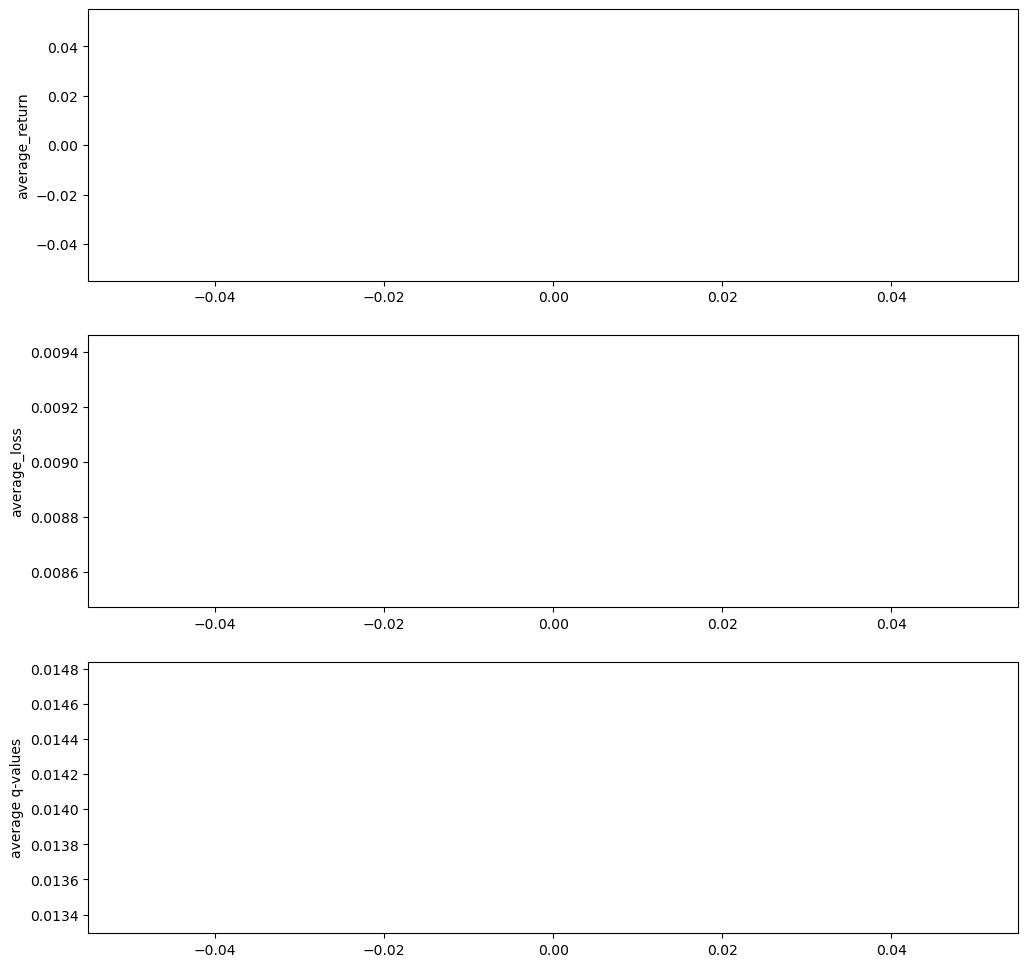

Training DQN:   0%|          | 1/30000 [00:14<120:19:43, 14.44s/it]

   average_return  average_loss  average q-values
0             0.0      0.008966          0.014067


Training DQN:   0%|          | 2/30000 [00:17<65:56:09,  7.91s/it] 

Training DQN:   0%|          | 50/30000 [02:58<27:11:10,  3.27s/it]

TESTING: Average return: 0.0, Average loss: 0.007871488109230995, Average q-value-estimation: 0.006238929927349091


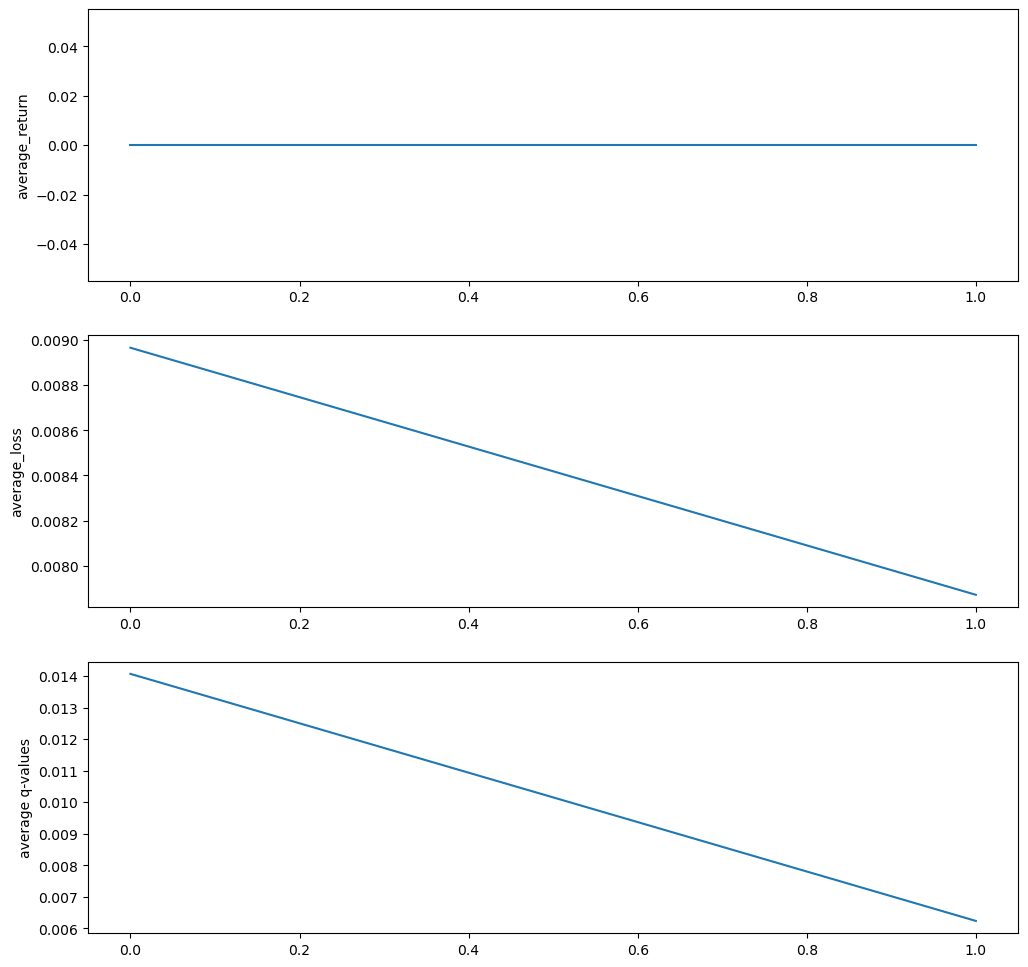

Training DQN:   0%|          | 51/30000 [03:09<47:41:40,  5.73s/it]

   average_return  average_loss  average q-values
0             0.0      0.008966          0.014067
1             0.0      0.007871          0.006239


Training DQN:   0%|          | 69/30000 [04:11<28:35:08,  3.44s/it]

In [50]:
# Run the DQN algorithm
dqn("ALE/Breakout-v5",gym.make("ALE/Breakout-v5").action_space.n)